In [2]:
import beepy
import numpy as np
import time
import datetime
from dateutil.relativedelta import relativedelta
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt

# Set token here
pro = ts.pro_api('')

In [8]:
# Helper functions

def countdown_timer(x, now=datetime.datetime.now):
    target = now()
    one_second_later = datetime.timedelta(seconds=1)
    for remaining in range(x, 0, -1):
        target += one_second_later
        print(datetime.timedelta(seconds=remaining), 'remaining', end='\r')
        time.sleep((target - now()).total_seconds())
    print('\nTIMER ended')
    
    
def get_data(pro, t, startDate, endDate, fileds):
    try:
        df = pro.daily(ts_code=t, start_date=startDate, end_date=endDate, fields='ts_code,trade_date,high,low,close')
    except:
        df = get_data(pro, t, startDate, endDate, fileds)
        
    return df

def get_all_hist_data(pro, stockdata, startDate, endDate, fields, step, savecsv=1):
    [rows, cols] = stockdata.shape
    frames = []
    for k in range(0,np.ceil(rows/step)):
    
        countdown_timer(60)
        print('\nStart batch', k)

        if(k == np.floor(rows/step)):
            tickers = stockdata['ts_code'][k*step:]
        else:
            tickers = stockdata['ts_code'][k*step:(k+1)*step]

        for t in tickers:
            df = get_data(pro, t, startDate, endDate, fields)
            print(t, end='\r')
            frames.append(df)
            if k == 7:
                if t is tickers[-1:].to_string(index=False).strip():
                    print("\nDone.")
                    beepy.beep(sound=1)
            else:
                if t is tickers[(k+1)*step - 1]:
                    print("\nDone.")
                    beepy.beep(sound=1)
                
    myStockData = pd.concat(frames, ignore_index=1)
    if savecsv == 1:
        myStockData.to_csv('myStockData.csv', encoding='utf-8-sig')
        
    return myStockData


def findStock(dataframe, queries):
    if 'high' in queries:
        mydf = dataframe.loc[(dataframe['high'] == queries['high'])]
    elif 'low' in queries:
        mydf = dataframe.loc[(dataframe['low'] == queries['low'])]

    candidates = np.unique(mydf['ts_code'])
    potentials = []
    for t in candidates:
        fData = dataframe.loc[(dataframe['ts_code']== t) & (dataframe['trade_date'] == 20200403) & (dataframe['close'] > queries['lower_bound']) & (dataframe['close'] < queries['upper_bound'])]
        if(len(fData) != 0):
            potentials.append(fData)
            
    beepy.beep(sound=1)
    return pd.concat(potentials, ignore_index=1)

In [70]:
stockdata = pd.read_csv('stock_tickers.csv')

# Time range
endDate = '20200405'
t = datetime.datetime.strptime(endDate, '%Y%m%d')
t_startDate = t - relativedelta(years=5)
startDate = t_startDate.strftime('%Y%m%d')

# Pause after step to avoid ip banned
step = 500

In [92]:
myStockData = pd.read_csv('myStockData.csv')
df = findStock(myStockData, {'high': 45.88, 'lower_bound':9, 'upper_bound':15})

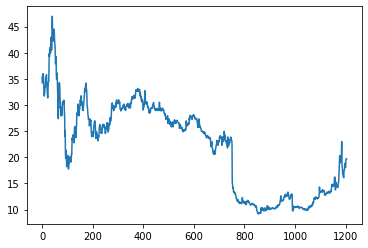

In [61]:
mydf = mydf.reset_index()
mydf = mydf
plt.plot(mydf['high'])
plt.show()